# Black Carbon Cross-Method Analysis

This notebook analyzes and compares black carbon measurements from three different methods:
1. Aethalometer (Red BCc)
2. FTIR (Elemental Carbon)
3. HIPS (Filter light absorption)

The analysis focuses on comparing these methods using 'excellent' quality data with minimal missing minutes.

## Imports and Setup

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os
from matplotlib.ticker import ScalarFormatter
from datetime import timedelta
from scipy.stats import pearsonr

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## Step 1: Data Loading Functions

These functions handle loading and preparing data from the Aethalometer, HIPS, and FTIR sources.

In [19]:
def load_aethalometer_data(file_path):
    """Load and prepare Aethalometer data."""
    print(f"Loading Aethalometer data from: {file_path}")
    
    try:
        # Try to use polars for faster loading if available
        try:
            import polars as pl
            print("Using Polars for data loading (faster)")
            pl_data = pl.read_csv(file_path)
            df = pl_data.to_pandas()
        except ImportError:
            print("Polars not available, using pandas")
            df = pd.read_csv(file_path)
    
        # Parse date and time columns if they exist
        datetime_col = None
        if 'Date local (yyyy/MM/dd)' in df.columns and 'Time local (hh:mm:ss)' in df.columns:
            # Try multiple formats to handle different date formats
            try:
                formats_to_try = [
                    '%Y-%m-%d %I:%M:%S %p',  # 2022-04-12 9:46:01 AM
                    '%Y/%m/%d %H:%M:%S',     # 2022/04/12 09:46:01
                    '%Y-%m-%d %H:%M:%S'      # 2022-04-12 09:46:01
                ]
                
                for fmt in formats_to_try:
                    try:
                        df['datetime_local'] = pd.to_datetime(
                            df['Date local (yyyy/MM/dd)'] + ' ' + df['Time local (hh:mm:ss)'],
                            format=fmt
                        )
                        datetime_col = 'datetime_local'
                        print(f"Successfully parsed dates with format: {fmt}")
                        break
                    except ValueError:
                        continue
                
                if datetime_col is None:
                    # If all specific formats fail, try the flexible approach
                    df['datetime_local'] = pd.to_datetime(
                        df['Date local (yyyy/MM/dd)'] + ' ' + df['Time local (hh:mm:ss)'],
                        format='mixed'
                    )
                    datetime_col = 'datetime_local'
                    print("Parsed dates using flexible 'mixed' format")
            except Exception as e:
                print(f"Error parsing date/time: {e}")
                print("Sample date values:", df['Date local (yyyy/MM/dd)'].iloc[:5].tolist())
                print("Sample time values:", df['Time local (hh:mm:ss)'].iloc[:5].tolist())
                return None
        elif 'datetime_local' in df.columns:
            # Column already exists
            df['datetime_local'] = pd.to_datetime(df['datetime_local'])
            datetime_col = 'datetime_local'
        
        # Set index if datetime column is found
        if datetime_col:
            df.set_index(datetime_col, inplace=True)
            df.index = df.index.floor('min')  # Ensure clean 1-min resolution
            df.sort_index(inplace=True)
        else:
            print("ERROR: No valid datetime column found")
            return None
        
        print(f"Loaded {len(df):,} Aethalometer records spanning {df.index.min()} to {df.index.max()}")
        
        # Check if Red BCc column exists
        if 'Red BCc' in df.columns:
            print(f"Red BCc data available: {df['Red BCc'].describe().round(2)}")
        else:
            print("WARNING: 'Red BCc' column not found in the dataset!")
            print("Available columns:", df.columns.tolist())
        
        return df
    
    except Exception as e:
        print(f"Error loading Aethalometer data: {e}")
        return None

In [20]:
def load_filter_sample_data(db_path):
    """Load ETAD (HIPS) and FTIR data from SQLite database."""
    print(f"Loading ETAD (HIPS) and FTIR filter sample data from: {db_path}")
    
    try:
        # Connect to the database
        conn = sqlite3.connect(db_path)
        
        # Load HIPS/FTIR data for the ETAD site
        query = """
        SELECT f.filter_id, 
               f.sample_date AS SampleDate, 
               m.ec_ftir AS EC_FTIR,
               m.oc_ftir AS OC_FTIR,
               m.fabs AS Fabs,
               f.site_code AS Site
        FROM filters f
        JOIN ftir_sample_measurements m USING(filter_id)
        WHERE f.site_code = 'ETAD'
        ORDER BY f.sample_date;
        """
        
        # Execute the query and load into a DataFrame
        combined_data = pd.read_sql_query(query, conn)
        
        # Convert date column to datetime
        combined_data['SampleDate'] = pd.to_datetime(combined_data['SampleDate'])
        
        # For compatibility with existing code, create separate dataframes for HIPS and FTIR
        # Both dataframes contain the same data since they're joined in the database
        etad_data = combined_data.copy()
        ftir_data = combined_data.copy()
        ftir_data.rename(columns={'SampleDate': 'date'}, inplace=True)
        
        # Display summary
        valid_samples_count = etad_data['SampleDate'].notna().sum()
        
        print(f"Loaded {len(etad_data)} ETAD samples from database ({valid_samples_count} with valid dates)")
        print(f"  - All samples have both HIPS and FTIR measurements")
        
        # Close the connection
        conn.close()
        
        return etad_data, ftir_data
    
    except Exception as e:
        print(f"Error loading filter sample data: {e}")
        print("Will attempt to create empty dataframes as fallback...")
        etad_data = pd.DataFrame(columns=['filter_id', 'SampleDate', 'Fabs', 'Site'])
        ftir_data = pd.DataFrame(columns=['filter_id', 'date', 'EC_FTIR', 'OC_FTIR'])
        return etad_data, ftir_data


In [21]:
def load_quality_periods(quality_file_path):
    """Load the quality period classifications from CSV file if available."""
    print(f"Looking for quality periods file: {quality_file_path}")
    
    try:
        if os.path.exists(quality_file_path):
            quality_df = pd.read_csv(quality_file_path)
            
            # Convert date columns to datetime
            if 'start_time' in quality_df.columns:
                quality_df['start_time'] = pd.to_datetime(quality_df['start_time'])
            if 'end_time' in quality_df.columns:
                quality_df['end_time'] = pd.to_datetime(quality_df['end_time'])
            
            print(f"Loaded {len(quality_df)} quality-classified periods")
            
            # Check if aethalometer_quality column exists
            if 'aethalometer_quality' in quality_df.columns:
                print(f"Quality distribution:")
                print(quality_df['aethalometer_quality'].value_counts())
            else:
                print("No 'aethalometer_quality' column found. Available columns:")
                print(quality_df.columns.tolist())
            
            return quality_df
        else:
            print(f"Quality periods file not found: {quality_file_path}")
            print("Will need to compute quality periods from scratch.")
            return None
    
    except Exception as e:
        print(f"Error loading quality periods: {e}")
        return None


## Step 2: Data Processing Functions

These functions identify 'excellent' data quality periods and extract the overlapping measurements.

In [22]:
def identify_excellent_periods(aethalometer_df, quality_df=None):
    """
    Identify excellent 9am-to-9am periods directly from Aethalometer data
    or from a pre-computed quality classification DataFrame.
    """
    if quality_df is not None and 'aethalometer_quality' in quality_df.columns:
        print("Using pre-computed quality classifications")
        
        # Extract excellent periods
        excellent_periods = quality_df[quality_df['aethalometer_quality'] == 'Excellent']
        print(f"Found {len(excellent_periods)} excellent periods in quality classifications")
        
        return excellent_periods
    
    print("Computing excellent periods from scratch")
    
    # Start and end timestamps
    start, end = aethalometer_df.index.min(), aethalometer_df.index.max()
    
    # Create expected full timeline
    expected_idx = pd.date_range(start, end, freq='min')
    
    # Identify missing timestamps
    actual_idx = aethalometer_df.index.unique().sort_values()
    missing_idx = expected_idx.difference(actual_idx)
    
    # Create 9am-to-9am periods (matching filter sampling)
    # Shift each timestamp to the previous 9am boundary
    nine_am_periods = missing_idx.map(lambda ts: 
        ts.normalize() + pd.Timedelta(hours=9) if ts.hour < 9 
        else ts.normalize() + pd.Timedelta(hours=9) + pd.Timedelta(days=1)
    )
    
    # Count missing minutes per 9am-to-9am period
    missing_per_period = pd.Series(1, index=nine_am_periods).groupby(level=0).count()
    
    # Classify excellent periods (≤10 minutes missing)
    excellent_periods_idx = missing_per_period[missing_per_period <= 10].index
    
    # Create a DataFrame with the excellent periods
    excellent_periods = pd.DataFrame(index=excellent_periods_idx)
    excellent_periods['start_time'] = excellent_periods.index
    excellent_periods['end_time'] = excellent_periods['start_time'] + pd.Timedelta(days=1)
    excellent_periods['aethalometer_quality'] = 'Excellent'
    
    print(f"Computed {len(excellent_periods)} excellent periods from scratch")
    
    return excellent_periods

In [23]:
def extract_daily_aethalometer_data(aethalometer_df, period_start, period_end, column='Red BCc'):
    """
    Extract and process Aethalometer data for a specific 24-hour period.
    Returns summary statistics for the period.
    """
    try:
        # Extract data for the specific period
        period_data = aethalometer_df.loc[period_start:period_end, column].dropna()
        
        if len(period_data) == 0:
            return None
        
        # Calculate statistics
        stats = {
            'period_start': period_start,
            'period_end': period_end,
            'count': len(period_data),
            'mean': period_data.mean(),
            'median': period_data.median(),
            'min': period_data.min(),
            'max': period_data.max(),
            'std': period_data.std(),
            '25th': period_data.quantile(0.25),
            '75th': period_data.quantile(0.75),
            'negative_count': (period_data < 0).sum(),
            'negative_percent': (period_data < 0).mean() * 100
        }
        
        return stats
    except Exception as e:
        print(f"Error extracting data for period {period_start} to {period_end}: {e}")
        return None

In [24]:
def find_overlapping_excellent_data(aethalometer_df, filter_df, excellent_periods):
    """
    Find days with overlapping excellent Aethalometer data and filter samples.
    Returns a DataFrame with the overlapping periods.
    """
    print("\nFinding overlapping excellent periods with filter samples...")
    
    # Print debug info
    print(f"Filter DataFrame columns: {filter_df.columns.tolist()}")
    print(f"Excellent periods columns: {excellent_periods.columns.tolist()}")
    
    # Check if required columns exist
    if 'SampleDate' not in filter_df.columns:
        print("ERROR: SampleDate column not found in filter_df")
        return None
    
    if 'start_time' not in excellent_periods.columns:
        print("ERROR: start_time column not found in excellent_periods")
        return None
    
    # Convert filter sample dates to 9am start time format (24h earlier than collection)
    filter_dates = filter_df['SampleDate'].dropna()
    print(f"Filter dates range: {filter_dates.min()} to {filter_dates.max()}")
    print(f"Total filter dates: {len(filter_dates)}")
    
    # Print a few sample filter dates to debug
    print("Sample filter dates (first 5):")
    for date in filter_dates.head(5):
        print(f"  - {date}")
    
    # Convert to 9am start time (24h earlier than collection)
    filter_periods = pd.DatetimeIndex([
        d.normalize() + pd.Timedelta(hours=9) 
        for d in filter_dates
    ])
    
    # Get excellent period start times
    excellent_starts = excellent_periods['start_time']
    print(f"Excellent periods range: {excellent_starts.min()} to {excellent_starts.max()}")
    print(f"Total excellent periods: {len(excellent_starts)}")
    
    # Print a few sample excellent periods to debug
    print("Sample excellent period start times (first 5):")
    for date in excellent_starts.head(5):
        print(f"  - {date}")
    
    # Find overlap
    overlap_periods = pd.DatetimeIndex(filter_periods).intersection(excellent_starts)
    
    print(f"Found {len(overlap_periods)} overlapping excellent periods with filter samples")
    
    if len(overlap_periods) == 0:
        print("No overlapping periods found - cannot proceed with comparison.")
        return None
    
    # Print a few sample overlap periods to debug
    print("Sample overlap periods (first 5):")
    for date in overlap_periods[:5]:
        print(f"  - {date}")
    
    # Create DataFrame with the overlapping periods
    overlap_df = pd.DataFrame(index=overlap_periods)
    overlap_df['start_time'] = overlap_df.index
    overlap_df['end_time'] = overlap_df['start_time'] + pd.Timedelta(days=1)
    
    # Add filter sample data
    # Map each 9am start time back to the filter collection date (24h later)
    filter_collection_dates = overlap_df['start_time'] + pd.Timedelta(days=1)
    
    # Match with filter data - with more debugging and flexible matching
    print("Adding filter data to overlap DataFrame...")
    filter_columns_added = False
    matches_found = 0
    
    for i, row in overlap_df.iterrows():
        # Get the filter collection date (24h after start time)
        collection_date = row['start_time'] + pd.Timedelta(days=1)
        
        # Try exact datetime match first
        matching_sample = filter_df[filter_df['SampleDate'] == collection_date]
        
        # If no exact match, try matching only the date part (ignoring time)
        if len(matching_sample) == 0:
            # Convert collection_date to date-only for comparison
            collection_date_only = collection_date.date()
            # Convert filter_df SampleDate to date-only for comparison
            matching_sample = filter_df[filter_df['SampleDate'].dt.date == collection_date_only]
            
            if len(matching_sample) > 0:
                print(f"Found date-only match for {collection_date} -> {matching_sample['SampleDate'].iloc[0]}")
        
        if len(matching_sample) > 0:
            matches_found += 1
            
            # Add filter data to the overlap DataFrame
            try:
                overlap_df.loc[i, 'filter_id'] = matching_sample['filter_id'].iloc[0]
                overlap_df.loc[i, 'EC_FTIR'] = matching_sample['EC_FTIR'].iloc[0]
                overlap_df.loc[i, 'Fabs'] = matching_sample['Fabs'].iloc[0]
                filter_columns_added = True
            except Exception as e:
                print(f"Error adding filter data for {collection_date}: {e}")
            
            # Process Aethalometer data for this period
            period_end = row['end_time']
            aeth_stats = extract_daily_aethalometer_data(aethalometer_df, row['start_time'], period_end)
            
            if aeth_stats:
                for key, value in aeth_stats.items():
                    if key not in ['period_start', 'period_end']:
                        overlap_df.loc[i, f'aeth_{key}'] = value
    
    print(f"Matched {matches_found} out of {len(overlap_df)} overlap periods with filter data")
    
    # Check if we successfully added any data
    if not filter_columns_added:
        print("WARNING: No filter data was added to the overlap DataFrame")
        print("This could be due to a mismatch in dates or missing columns")
        
        # Attempt a more lenient approach - match filter collection dates to the day before excellent periods
        print("\nAttempting alternative date matching approach...")
        
        # Create a set of all filter collection dates (date only, no time)
        filter_dates_set = set(date.date() for date in filter_df['SampleDate'] if not pd.isna(date))
        
        # Create a new DataFrame to store matches
        new_overlap_df = pd.DataFrame()
        
        # For each filter date, find the corresponding excellent period
        matches = 0
        for collection_date in filter_dates_set:
            # Convert to datetime for easier manipulation
            collection_dt = pd.Timestamp(collection_date)
            
            # Find the excellent period that started 24h before this collection date
            start_time = collection_dt.normalize() + pd.Timedelta(hours=9) - pd.Timedelta(days=1)
            
            # Check if this start time is in excellent_periods
            if start_time in excellent_starts.values:
                matches += 1
                
                # Get filter data
                matching_filter = filter_df[filter_df['SampleDate'].dt.date == collection_date]
                
                if len(matching_filter) > 0:
                    # Create a new row for this match
                    new_row = pd.DataFrame({
                        'start_time': [start_time],
                        'end_time': [start_time + pd.Timedelta(days=1)],
                        'filter_id': [matching_filter['filter_id'].iloc[0]],
                        'EC_FTIR': [matching_filter['EC_FTIR'].iloc[0]],
                        'Fabs': [matching_filter['Fabs'].iloc[0]]
                    })
                    
                    # Add Aethalometer data
                    aeth_stats = extract_daily_aethalometer_data(
                        aethalometer_df, start_time, start_time + pd.Timedelta(days=1)
                    )
                    
                    if aeth_stats:
                        for key, value in aeth_stats.items():
                            if key not in ['period_start', 'period_end']:
                                new_row[f'aeth_{key}'] = value
                    
                    # Append to our new DataFrame
                    new_overlap_df = pd.concat([new_overlap_df, new_row], ignore_index=True)
        
        if matches > 0:
            print(f"Alternative approach found {matches} matches")
            if len(new_overlap_df) > 0:
                print(f"Successfully created alternate overlap DataFrame with {len(new_overlap_df)} rows")
                print(f"Columns: {new_overlap_df.columns.tolist()}")
                return new_overlap_df
    
    # Check which columns exist before dropping
    print(f"Overlap DataFrame columns: {overlap_df.columns.tolist()}")
    
    # Define required columns
    required_cols = ['filter_id', 'aeth_mean']
    missing_cols = [col for col in required_cols if col not in overlap_df.columns]
    
    if missing_cols:
        print(f"WARNING: Missing required columns: {missing_cols}")
        print("Keeping all rows for now")
    else:
        # Drop any rows without filter or Aethalometer data
        print("Dropping rows with missing filter or Aethalometer data...")
        orig_len = len(overlap_df)
        print(f"Dropped {orig_len - len(overlap_df)} incomplete rows")
    
    print(f"Final count of complete overlapping periods: {len(overlap_df)}")
    
    return overlap_df

## Step 3: Visualization Functions

These functions create various plots to compare the different black carbon measurement methods.

In [25]:
def plot_bc_scatter(overlap_df, y_param='EC_FTIR', title_prefix="Red BCc vs"):
    """
    Create a scatter plot comparing Aethalometer Red BCc with FTIR EC or HIPS Fabs.
    """
    param_labels = {
        'EC_FTIR': 'FTIR EC (μg/m³)',
        'Fabs': 'HIPS Fabs'
    }
    
    if y_param not in overlap_df.columns:
        print(f"Parameter {y_param} not found in data. Available columns:")
        print(overlap_df.columns.tolist())
        return
    
    if 'aeth_mean' not in overlap_df.columns:
        print("aeth_mean column not found. Available columns:")
        print(overlap_df.columns.tolist())
        return
    
    # Prepare data
    x = overlap_df['aeth_mean'] / 1000  # Convert from ng/m³ to μg/m³
    y = overlap_df[y_param]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot scatter points
    scatter = ax.scatter(x, y, alpha=0.7, s=80, c='blue', edgecolor='black')
    
    # Calculate and add trendline
    mask = ~np.isnan(x) & ~np.isnan(y)
    if mask.sum() > 1:  # Need at least 2 valid points for regression
        slope, intercept = np.polyfit(x[mask], y[mask], 1)
        x_line = np.linspace(x.min(), x.max(), 100)
        y_line = slope * x_line + intercept
        ax.plot(x_line, y_line, 'r--', linewidth=2)
        
        # Add regression equation and R² to plot
        r_value = pearsonr(x[mask], y[mask])[0]
        r_squared = r_value**2
        
        equation = f"y = {slope:.3f}x + {intercept:.3f}"
        r2_text = f"R² = {r_squared:.3f}"
        
        ax.annotate(
            equation + '\n' + r2_text,
            xy=(0.05, 0.95),
            xycoords='axes fraction',
            fontsize=12,
            ha='left',
            va='top',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
        )
    
    # Format plot
    ax.set_xlabel('Aethalometer Red BCc (μg/m³)', fontsize=12)
    ax.set_ylabel(param_labels.get(y_param, y_param), fontsize=12)
    ax.set_title(f"{title_prefix} {param_labels.get(y_param, y_param)}\n"
                f"Using {len(x)} 'Excellent' 24-hour periods", fontsize=14)
    
    # Make sure axes start at 0 if all data is positive
    if x.min() >= 0 and y.min() >= 0:
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=0)
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add 1:1 line if units are comparable
    if y_param == 'EC_FTIR':
        max_val = max(x.max(), y.max()) * 1.1
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, linewidth=1, label='1:1 Line')
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [26]:
def plot_method_comparison(overlap_df):
    """
    Create plots comparing all three methods: Aethalometer Red BCc, FTIR EC, and HIPS Fabs.
    """
    if len(overlap_df) == 0:
        print("No data available for method comparison.")
        return
    
    # Check for required columns
    required_cols = ['aeth_mean', 'EC_FTIR', 'Fabs']
    missing_cols = [col for col in required_cols if col not in overlap_df.columns]
    
    if missing_cols:
        print(f"Missing required columns for method comparison: {missing_cols}")
        print(f"Available columns: {overlap_df.columns.tolist()}")
        return
    
    # Convert Aethalometer BC from ng/m³ to μg/m³
    overlap_df['aeth_mean_ug'] = overlap_df['aeth_mean'] / 1000
    
    # Create figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Plot 1: Red BCc vs EC_FTIR
    ax1 = axes[0]
    x1 = overlap_df['aeth_mean_ug']
    y1 = overlap_df['EC_FTIR']
    
    scatter1 = ax1.scatter(x1, y1, alpha=0.7, s=80, c='blue', edgecolor='black')
    
    # Calculate and add trendline
    mask1 = ~np.isnan(x1) & ~np.isnan(y1)
    if mask1.sum() > 1:
        slope1, intercept1 = np.polyfit(x1[mask1], y1[mask1], 1)
        x_line1 = np.linspace(x1.min(), x1.max(), 100)
        y_line1 = slope1 * x_line1 + intercept1
        ax1.plot(x_line1, y_line1, 'r--', linewidth=2)
        
        # Add regression equation and R²
        r_value1 = pearsonr(x1[mask1], y1[mask1])[0]
        r_squared1 = r_value1**2
        
        equation1 = f"y = {slope1:.3f}x + {intercept1:.3f}"
        r2_text1 = f"R² = {r_squared1:.3f}"
        
        ax1.annotate(
            equation1 + '\n' + r2_text1,
            xy=(0.05, 0.95),
            xycoords='axes fraction',
            fontsize=12,
            ha='left',
            va='top',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
        )
    
    # Format plot 1
    ax1.set_xlabel('Aethalometer Red BCc (μg/m³)', fontsize=12)
    ax1.set_ylabel('FTIR EC (μg/m³)', fontsize=12)
    ax1.set_title(f"Red BCc vs FTIR EC\n({len(x1)} 'Excellent' 24-hour periods)", fontsize=14)
    
    # Add 1:1 line
    max_val1 = max(x1.max(), y1.max()) * 1.1
    ax1.plot([0, max_val1], [0, max_val1], 'k--', alpha=0.3, linewidth=1, label='1:1 Line')
    ax1.legend()
    
    # Plot 2: Red BCc vs HIPS Fabs
    ax2 = axes[1]
    x2 = overlap_df['aeth_mean_ug']
    y2 = overlap_df['Fabs']
    
    scatter2 = ax2.scatter(x2, y2, alpha=0.7, s=80, c='green', edgecolor='black')
    
    # Calculate and add trendline
    mask2 = ~np.isnan(x2) & ~np.isnan(y2)
    if mask2.sum() > 1:
        slope2, intercept2 = np.polyfit(x2[mask2], y2[mask2], 1)
        x_line2 = np.linspace(x2.min(), x2.max(), 100)
        y_line2 = slope2 * x_line2 + intercept2
        ax2.plot(x_line2, y_line2, 'r--', linewidth=2)
        
        # Add regression equation and R²
        r_value2 = pearsonr(x2[mask2], y2[mask2])[0]
        r_squared2 = r_value2**2
        
        equation2 = f"y = {slope2:.3f}x + {intercept2:.3f}"
        r2_text2 = f"R² = {r_squared2:.3f}"
        
        ax2.annotate(
            equation2 + '\n' + r2_text2,
            xy=(0.05, 0.95),
            xycoords='axes fraction',
            fontsize=12,
            ha='left',
            va='top',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
        )
    
    # Format plot 2
    ax2.set_xlabel('Aethalometer Red BCc (μg/m³)', fontsize=12)
    ax2.set_ylabel('HIPS Fabs', fontsize=12)
    ax2.set_title(f"Red BCc vs HIPS Fabs\n({len(x2)} 'Excellent' 24-hour periods)", fontsize=14)
    
    # Make sure axes start at 0 if all data is positive
    for ax, x, y in [(ax1, x1, y1), (ax2, x2, y2)]:
        if x.min() >= 0 and y.min() >= 0:
            ax.set_xlim(left=0)
            ax.set_ylim(bottom=0)
        ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [27]:
def plot_seasonal_comparison(overlap_df):
    """
    Create plots comparing methods with seasonal color-coding.
    """
    if len(overlap_df) == 0:
        print("No data available for seasonal comparison.")
        return
    
    # Check for required columns
    required_cols = ['aeth_mean', 'EC_FTIR', 'Fabs', 'start_time']
    missing_cols = [col for col in required_cols if col not in overlap_df.columns]
    
    if missing_cols:
        print(f"Missing required columns for seasonal comparison: {missing_cols}")
        print(f"Available columns: {overlap_df.columns.tolist()}")
        return
    
    # Add date and season information
    overlap_df['date'] = overlap_df['start_time'].dt.date
    overlap_df['month'] = overlap_df['start_time'].dt.month
    
    # Map Ethiopian seasons
    def map_ethiopian_seasons(month):
        """Maps month number to Ethiopian season name."""
        if month in [10, 11, 12, 1, 2]:
            return 'Dry Season'
        elif month in [3, 4, 5]:
            return 'Belg Rainy Season'
        else:  # months 6–9
            return 'Kiremt Rainy Season'
    
    overlap_df['season'] = overlap_df['month'].apply(map_ethiopian_seasons)
    
    # Convert Aethalometer BC from ng/m³ to μg/m³
    overlap_df['aeth_mean_ug'] = overlap_df['aeth_mean'] / 1000
    
    # Create figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Define colors for seasons
    season_colors = {
        'Dry Season': 'gold',
        'Belg Rainy Season': 'limegreen',
        'Kiremt Rainy Season': 'royalblue'
    }
    
    # Plot 1: Red BCc vs EC_FTIR by season
    ax1 = axes[0]
    
    # Separate scatter plots for each season
    for season, color in season_colors.items():
        season_data = overlap_df[overlap_df['season'] == season]
        if len(season_data) > 0:
            ax1.scatter(
                season_data['aeth_mean_ug'], 
                season_data['EC_FTIR'],
                alpha=0.7, 
                s=80, 
                c=color, 
                edgecolor='black',
                label=f"{season} (n={len(season_data)})"
            )
    
    # Overall trendline
    x1 = overlap_df['aeth_mean_ug']
    y1 = overlap_df['EC_FTIR']
    mask1 = ~np.isnan(x1) & ~np.isnan(y1)
    
    if mask1.sum() > 1:
        slope1, intercept1 = np.polyfit(x1[mask1], y1[mask1], 1)
        x_line1 = np.linspace(x1.min(), x1.max(), 100)
        y_line1 = slope1 * x_line1 + intercept1
        ax1.plot(x_line1, y_line1, 'r--', linewidth=2, label='All Seasons Fit')
        
        # Add regression equation and R²
        r_value1 = pearsonr(x1[mask1], y1[mask1])[0]
        r_squared1 = r_value1**2
        
        equation1 = f"y = {slope1:.3f}x + {intercept1:.3f}"
        r2_text1 = f"R² = {r_squared1:.3f}"
        
        ax1.annotate(
            equation1 + '\n' + r2_text1,
            xy=(0.05, 0.95),
            xycoords='axes fraction',
            fontsize=12,
            ha='left',
            va='top',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
        )
    
    # Format plot 1
    ax1.set_xlabel('Aethalometer Red BCc (μg/m³)', fontsize=12)
    ax1.set_ylabel('FTIR EC (μg/m³)', fontsize=12)
    ax1.set_title(f"Red BCc vs FTIR EC by Ethiopian Season\n({len(x1)} 'Excellent' 24-hour periods)", fontsize=14)
    
    # Add 1:1 line
    max_val1 = max(x1.max(), y1.max()) * 1.1
    ax1.plot([0, max_val1], [0, max_val1], 'k--', alpha=0.3, linewidth=1, label='1:1 Line')
    ax1.legend()
    
    # Plot 2: Red BCc vs HIPS Fabs by season
    ax2 = axes[1]
    
    # Separate scatter plots for each season
    for season, color in season_colors.items():
        season_data = overlap_df[overlap_df['season'] == season]
        if len(season_data) > 0:
            ax2.scatter(
                season_data['aeth_mean_ug'], 
                season_data['Fabs'],
                alpha=0.7, 
                s=80, 
                c=color, 
                edgecolor='black',
                label=f"{season} (n={len(season_data)})"
            )
    
    # Overall trendline
    x2 = overlap_df['aeth_mean_ug']
    y2 = overlap_df['Fabs']
    mask2 = ~np.isnan(x2) & ~np.isnan(y2)
    
    if mask2.sum() > 1:
        slope2, intercept2 = np.polyfit(x2[mask2], y2[mask2], 1)
        x_line2 = np.linspace(x2.min(), x2.max(), 100)
        y_line2 = slope2 * x_line2 + intercept2
        ax2.plot(x_line2, y_line2, 'r--', linewidth=2, label='All Seasons Fit')
        
        # Add regression equation and R²
        r_value2 = pearsonr(x2[mask2], y2[mask2])[0]
        r_squared2 = r_value2**2
        
        equation2 = f"y = {slope2:.3f}x + {intercept2:.3f}"
        r2_text2 = f"R² = {r_squared2:.3f}"
        
        ax2.annotate(
            equation2 + '\n' + r2_text2,
            xy=(0.05, 0.95),
            xycoords='axes fraction',
            fontsize=12,
            ha='left',
            va='top',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
        )
    
    # Format plot 2
    ax2.set_xlabel('Aethalometer Red BCc (μg/m³)', fontsize=12)
    ax2.set_ylabel('HIPS Fabs', fontsize=12)
    ax2.set_title(f"Red BCc vs HIPS Fabs by Ethiopian Season\n({len(x2)} 'Excellent' 24-hour periods)", fontsize=14)
    
    # Make sure axes start at 0 if all data is positive
    for ax, x, y in [(ax1, x1, y1), (ax2, x2, y2)]:
        if x.min() >= 0 and y.min() >= 0:
            ax.set_xlim(left=0)
            ax.set_ylim(bottom=0)
        ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Create seasonal regression stats table
    season_stats = []
    for season in season_colors.keys():
        season_data = overlap_df[overlap_df['season'] == season]
        if len(season_data) > 1:  # Need at least 2 points for regression
            # For Red BCc vs EC_FTIR
            x_aeth = season_data['aeth_mean_ug'].values
            y_ec = season_data['EC_FTIR'].values
            mask_ec = ~np.isnan(x_aeth) & ~np.isnan(y_ec)
            
            if mask_ec.sum() > 1:
                slope_ec, intercept_ec = np.polyfit(x_aeth[mask_ec], y_ec[mask_ec], 1)
                r_value_ec = pearsonr(x_aeth[mask_ec], y_ec[mask_ec])[0]
                r_squared_ec = r_value_ec**2
                
                # For Red BCc vs HIPS Fabs
                y_fabs = season_data['Fabs'].values
                mask_fabs = ~np.isnan(x_aeth) & ~np.isnan(y_fabs)
                
                if mask_fabs.sum() > 1:
                    slope_fabs, intercept_fabs = np.polyfit(x_aeth[mask_fabs], y_fabs[mask_fabs], 1)
                    r_value_fabs = pearsonr(x_aeth[mask_fabs], y_fabs[mask_fabs])[0]
                    r_squared_fabs = r_value_fabs**2
                    
                    # Add to stats table
                    season_stats.append({
                        'Season': season,
                        'Count': len(season_data),
                        'EC_FTIR_Slope': slope_ec,
                        'EC_FTIR_Intercept': intercept_ec,
                        'EC_FTIR_R2': r_squared_ec,
                        'Fabs_Slope': slope_fabs,
                        'Fabs_Intercept': intercept_fabs,
                        'Fabs_R2': r_squared_fabs
                    })
    
    # Create and display seasonal stats DataFrame
    if season_stats:
        season_stats_df = pd.DataFrame(season_stats)
        print("\nSeasonal Regression Statistics:")
        print(season_stats_df.round(3))
        return fig, season_stats_df
    
    return fig

In [28]:
def calculate_mac_values(overlap_df):
    """
    Calculate Mass Absorption Cross-section (MAC) values from Red BCc and EC_FTIR data.
    """
    # Check for required columns
    required_cols = ['aeth_mean', 'EC_FTIR', 'Fabs']
    missing_cols = [col for col in required_cols if col not in overlap_df.columns]
    
    if missing_cols:
        print(f"Missing required columns for MAC calculation: {missing_cols}")
        print(f"Available columns: {overlap_df.columns.tolist()}")
        return None
    
    # Create a copy of the data
    mac_df = overlap_df.copy()
    
    # Add date and season information if not already present
    if 'date' not in mac_df.columns and 'start_time' in mac_df.columns:
        mac_df['date'] = mac_df['start_time'].dt.date
    
    if 'month' not in mac_df.columns and 'start_time' in mac_df.columns:
        mac_df['month'] = mac_df['start_time'].dt.month
    
    if 'season' not in mac_df.columns and 'month' in mac_df.columns:
        # Map Ethiopian seasons
        def map_ethiopian_seasons(month):
            """Maps month number to Ethiopian season name."""
            if month in [10, 11, 12, 1, 2]:
                return 'Dry Season'
            elif month in [3, 4, 5]:
                return 'Belg Rainy Season'
            else:  # months 6–9
                return 'Kiremt Rainy Season'
        
        mac_df['season'] = mac_df['month'].apply(map_ethiopian_seasons)
    
    # Convert Aethalometer BC from ng/m³ to μg/m³
    mac_df['aeth_mean_ug'] = mac_df['aeth_mean'] / 1000
    
    # Calculate the Red MACs (Mass Absorption Cross-section)
    # For red channel (typically 660 nm), babs = BC × MAC
    # To get Babs, we calculate BC (μg/m³) × MAC (m²/g) × 10^-6 (g/μg) × 10^6 (1/Mm) = BC × MAC
    # Re-arranged, MAC = babs/BC
    
    # Assumes babs (absorption) is proportional to BC with the MAC as the conversion factor
    # We can estimate MAC by comparing BC to EC since EC should be the correct mass
    mac_df['red_mac'] = mac_df['Fabs'] / mac_df['EC_FTIR']  # in m²/g
    
    # Filter out invalid MAC values (negative, zero, or very extreme)
    mac_df = mac_df[(mac_df['red_mac'] > 0) & (mac_df['red_mac'] < 30)]  # typical MACs are 5-15 m²/g
    
    # Calculate statistics
    overall_mac = mac_df['red_mac'].mean()
    seasonal_macs = mac_df.groupby('season')['red_mac'].agg(['mean', 'std', 'count'])
    
    print("\nMass Absorption Cross-section (MAC) Values for Red Channel:")
    print(f"Overall MAC: {overall_mac:.2f} m²/g (n={len(mac_df)})")
    print("\nSeasonal MAC Values:")
    print(seasonal_macs.round(2))
    
    # Plot MAC values
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Plot 1: MAC histogram
    ax1 = axes[0]
    ax1.hist(mac_df['red_mac'], bins=15, alpha=0.7, color='crimson', edgecolor='black')
    ax1.axvline(overall_mac, color='black', linestyle='--', linewidth=2, 
                label=f'Mean MAC: {overall_mac:.2f} m²/g')
    ax1.set_xlabel('Red MAC (m²/g)', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.set_title(f'Distribution of Red MAC Values\n({len(mac_df)} Excellent Quality Days)', fontsize=14)
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Plot 2: MAC boxplot by season
    ax2 = axes[1]
    sns.boxplot(x='season', y='red_mac', data=mac_df, ax=ax2, palette='Set3')
    ax2.set_xlabel('Ethiopian Season', fontsize=12)
    ax2.set_ylabel('Red MAC (m²/g)', fontsize=12)
    ax2.set_title('Red MAC Values by Season', fontsize=14)
    
    # Add sample counts to season labels
    season_counts = mac_df['season'].value_counts()
    new_labels = []
    for tick_label in ax2.get_xticklabels():
        season = tick_label.get_text()
        count = season_counts.get(season, 0)
        new_labels.append(f'{season}\n(n={count})')
    ax2.set_xticklabels(new_labels)
    
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return mac_df, fig

In [29]:
def analyze_time_series(overlap_df):
    """
    Create time series plots comparing the three methods over time.
    """
    # Check for required columns
    required_cols = ['aeth_mean', 'EC_FTIR', 'Fabs', 'start_time']
    missing_cols = [col for col in required_cols if col not in overlap_df.columns]
    
    if missing_cols:
        print(f"Missing required columns for time series analysis: {missing_cols}")
        print(f"Available columns: {overlap_df.columns.tolist()}")
        return
    
    # Create a copy of the data
    ts_df = overlap_df.copy()
    
    # Ensure we have a date column
    if 'date' not in ts_df.columns:
        ts_df['date'] = ts_df['start_time'].dt.date
    
    # Sort by date
    ts_df = ts_df.sort_values('start_time')
    
    # Convert Aethalometer BC from ng/m³ to μg/m³
    ts_df['aeth_mean_ug'] = ts_df['aeth_mean'] / 1000
    
    # Create figure
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Plot time series
    ax.plot(ts_df['start_time'], ts_df['aeth_mean_ug'], 'o-', color='blue', 
            markersize=8, label='Aethalometer Red BCc')
    ax.plot(ts_df['start_time'], ts_df['EC_FTIR'], 's-', color='green', 
            markersize=8, label='FTIR EC')
    
    # Create a twin y-axis for Fabs
    ax2 = ax.twinx()
    ax2.plot(ts_df['start_time'], ts_df['Fabs'], '^-', color='red', 
             markersize=8, label='HIPS Fabs')
    
    # Format axes
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Concentration (μg/m³)', fontsize=12)
    ax2.set_ylabel('HIPS Fabs', fontsize=12, color='red')
    ax2.tick_params(axis='y', colors='red')
    
    # Combine legends
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    ax.set_title('Time Series Comparison of Methods\n(Excellent Quality Days)', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Format x-axis dates
    fig.autofmt_xdate()
    
    plt.tight_layout()
    plt.show()
    
    # Also create a seasonal time series
    if 'season' not in ts_df.columns:
        # Map Ethiopian seasons
        def map_ethiopian_seasons(month):
            """Maps month number to Ethiopian season name."""
            if month in [10, 11, 12, 1, 2]:
                return 'Dry Season'
            elif month in [3, 4, 5]:
                return 'Belg Rainy Season'
            else:  # months 6–9
                return 'Kiremt Rainy Season'
        
        ts_df['month'] = ts_df['start_time'].dt.month
        ts_df['season'] = ts_df['month'].apply(map_ethiopian_seasons)
    
    # Create a new figure for seasonal comparison
    fig2, axes = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
    
    # Colors for different measurement methods
    colors = {
        'aeth_mean_ug': 'blue',
        'EC_FTIR': 'green',
        'Fabs': 'red'
    }
    
    # Plot each season separately
    seasons = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
    
    for i, season in enumerate(seasons):
        season_data = ts_df[ts_df['season'] == season]
        
        if len(season_data) > 0:
            axes[i].plot(season_data['start_time'], season_data['aeth_mean_ug'], 'o-', 
                        color=colors['aeth_mean_ug'], markersize=8, label='Aethalometer Red BCc')
            axes[i].plot(season_data['start_time'], season_data['EC_FTIR'], 's-', 
                        color=colors['EC_FTIR'], markersize=8, label='FTIR EC')
            
            # Create a twin y-axis for Fabs
            ax2 = axes[i].twinx()
            ax2.plot(season_data['start_time'], season_data['Fabs'], '^-', 
                    color=colors['Fabs'], markersize=8, label='HIPS Fabs')
            ax2.set_ylabel('HIPS Fabs', fontsize=12, color=colors['Fabs'])
            
            # Format axes
            axes[i].set_title(f'{season} (n={len(season_data)})', fontsize=14)
            axes[i].set_ylabel('Concentration (μg/m³)', fontsize=12)
            axes[i].grid(True, linestyle='--', alpha=0.7)
            
            # Add legend to first plot only
            if i == 0:
                lines1, labels1 = axes[i].get_legend_handles_labels()
                lines2, labels2 = ax2.get_legend_handles_labels()
                axes[i].legend(lines1 + lines2, labels1 + labels2, loc='upper right')
        else:
            axes[i].text(0.5, 0.5, f'No data for {season}', 
                        horizontalalignment='center', verticalalignment='center',
                        transform=axes[i].transAxes, fontsize=14)
    
    # Format shared x-axis
    axes[2].set_xlabel('Date', fontsize=12)
    fig2.autofmt_xdate()
    
    plt.tight_layout()
    plt.show()
    
    return fig, fig2

## Step 4: Main Execution Function

This function brings together all the components to perform the complete analysis.

In [30]:

def main():
    """
    Main execution function to perform the black carbon cross-method analysis.
    """
    print("Black Carbon Cross-Method Analysis")
    print("=================================")
    print("This script analyzes excellent quality data from:")
    print("1. Aethalometer (Red BCc)")
    print("2. FTIR (Elemental Carbon)")
    print("3. HIPS (Filter light absorption)")
    print("=================================\n")
    
    # Define file paths - adjust these to your actual file paths
    aethalometer_path = "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Aethelometry Data/Jacros_MA350_1-min_2022-2024_Cleaned.csv"
    db_path = "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/EC-HIPS-Aeth Comparison/Data/Original Data/Combined Database/spartan_ftir_hips.db"
    quality_file_path = "all_filter_dates_with_complete_quality_9to9.csv"
    
    # Load Aethalometer data
    print("\n--- Loading Aethalometer Data ---")
    aethalometer_df = load_aethalometer_data(aethalometer_path)
    
    if aethalometer_df is None:
        print("ERROR: Failed to load Aethalometer data. Exiting.")
        return
    
    # Load filter sample data
    print("\n--- Loading Filter Sample Data ---")
    etad_data, ftir_data = load_filter_sample_data(db_path)
    
    if len(etad_data) == 0:
        print("ERROR: No filter sample data available. Exiting.")
        return
    
    # Load or identify excellent periods
    print("\n--- Identifying Excellent Quality Periods ---")
    quality_df = load_quality_periods(quality_file_path)
    excellent_periods = identify_excellent_periods(aethalometer_df, quality_df)
    
    if excellent_periods is None or len(excellent_periods) == 0:
        print("ERROR: No excellent quality periods identified. Exiting.")
        return
    
    # Find overlapping periods
    print("\n--- Finding Overlapping Periods ---")
    overlap_df = find_overlapping_excellent_data(aethalometer_df, etad_data, excellent_periods)
    
    if overlap_df is None or len(overlap_df) == 0:
        print("ERROR: No overlapping periods found. Exiting.")
        return
    
    # Create visualization plots
    print("\n--- Creating Cross-Method Plots ---")
    print(f"Using {len(overlap_df)} days with excellent data from all three methods")
    
    # Basic scatter plots
    try:
        plot_bc_scatter(overlap_df, y_param='EC_FTIR', title_prefix="Red BCc vs")
        plot_bc_scatter(overlap_df, y_param='Fabs', title_prefix="Red BCc vs")
    except Exception as e:
        print(f"Error creating scatter plots: {e}")
    
    # Comprehensive method comparison
    try:
        plot_method_comparison(overlap_df)
    except Exception as e:
        print(f"Error creating method comparison: {e}")
    
    # Seasonal comparison
    try:
        fig_seasonal, season_stats = plot_seasonal_comparison(overlap_df)
    except Exception as e:
        print(f"Error in seasonal comparison: {e}")
        season_stats = None
    
    # Calculate MAC values
    try:
        mac_df, fig_mac = calculate_mac_values(overlap_df)
    except Exception as e:
        print(f"Error in MAC calculation: {e}")
        mac_df = None
    
    # Time series analysis
    try:
        fig_ts, fig_ts_seasonal = analyze_time_series(overlap_df)
    except Exception as e:
        print(f"Error in time series analysis: {e}")
    
    print("\n--- Analysis Complete ---")
    print(f"Successfully analyzed {len(overlap_df)} overlapping excellent quality days")
    
    # Return results for further analysis if needed
    return {
        'aethalometer_df': aethalometer_df,
        'filter_df': etad_data,
        'excellent_periods': excellent_periods,
        'overlap_df': overlap_df,
        'mac_df': mac_df,
        'season_stats': season_stats
    }

## Run the Analysis

Execute the main function to perform the complete black carbon cross-method analysis.

Black Carbon Cross-Method Analysis
This script analyzes excellent quality data from:
1. Aethalometer (Red BCc)
2. FTIR (Elemental Carbon)
3. HIPS (Filter light absorption)


--- Loading Aethalometer Data ---
Loading Aethalometer data from: /Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Aethelometry Data/Jacros_MA350_1-min_2022-2024_Cleaned.csv
Using Polars for data loading (faster)
Successfully parsed dates with format: %Y-%m-%d %I:%M:%S %p
Loaded 1,095,086 Aethalometer records spanning 2022-04-12 09:46:00 to 2024-08-20 09:01:00
Red BCc data available: count    1094754.00
mean        8084.10
std         9291.06
min      -182273.00
25%         2928.00
50%         5382.00
75%         9733.00
max       583168.00
Name: Red BCc, dtype: float64

--- Loading Filter Sample Data ---
Loading ETAD (HIPS) and FTIR filter sample data from: /Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/Unive

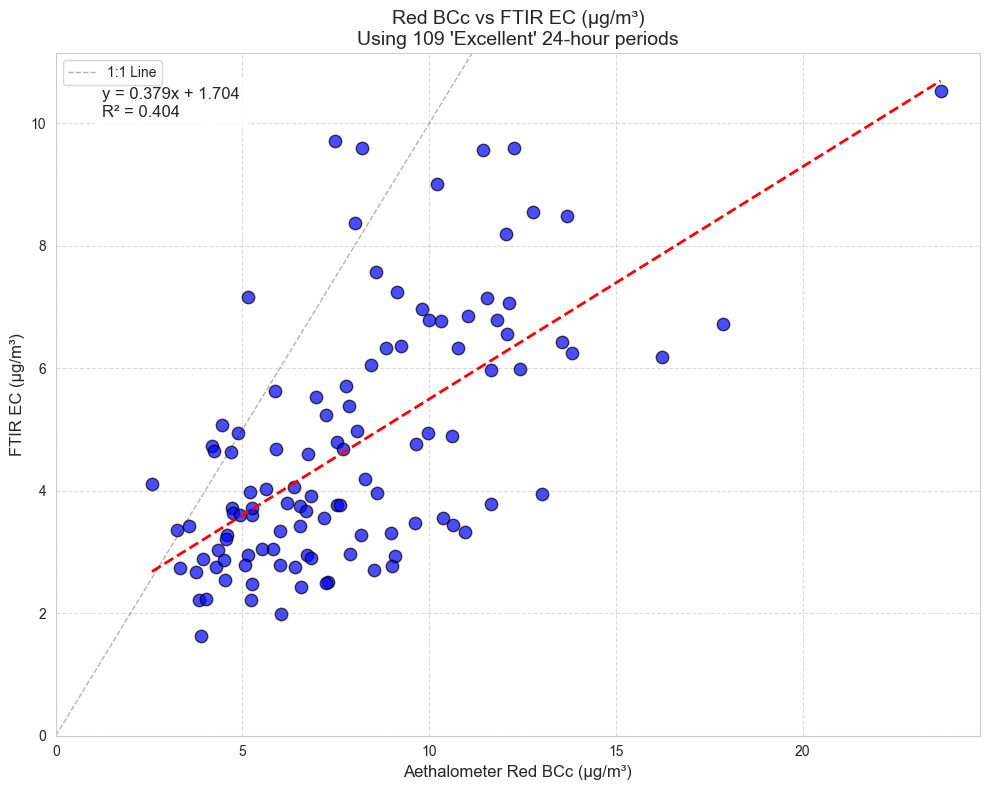

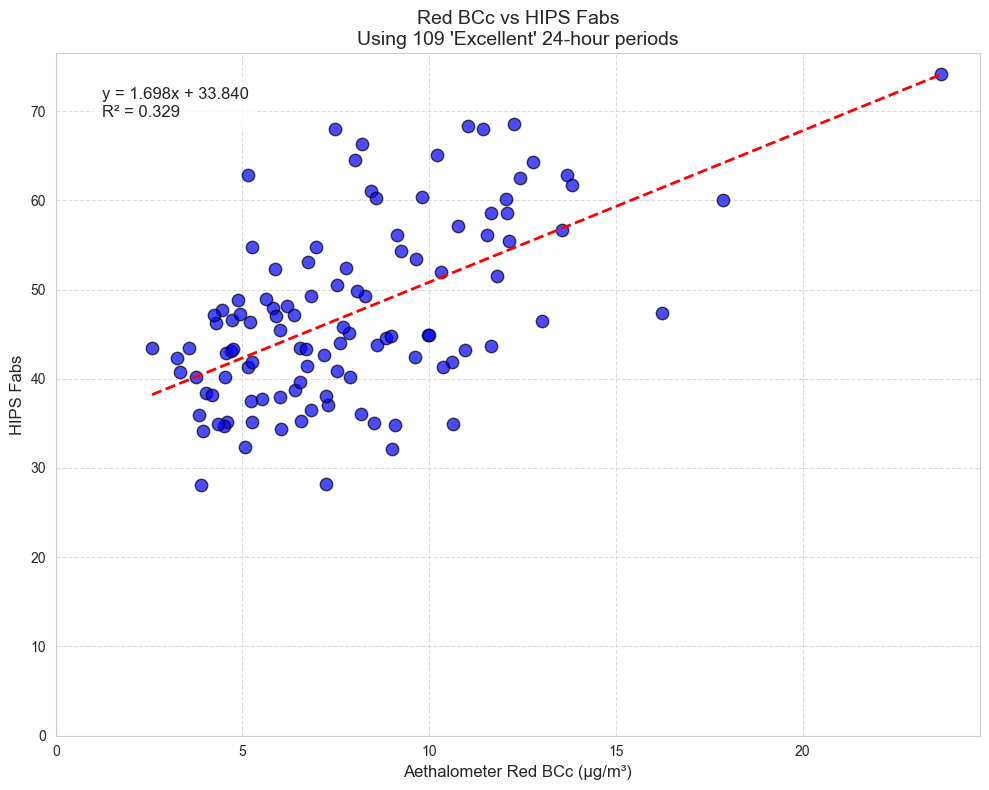

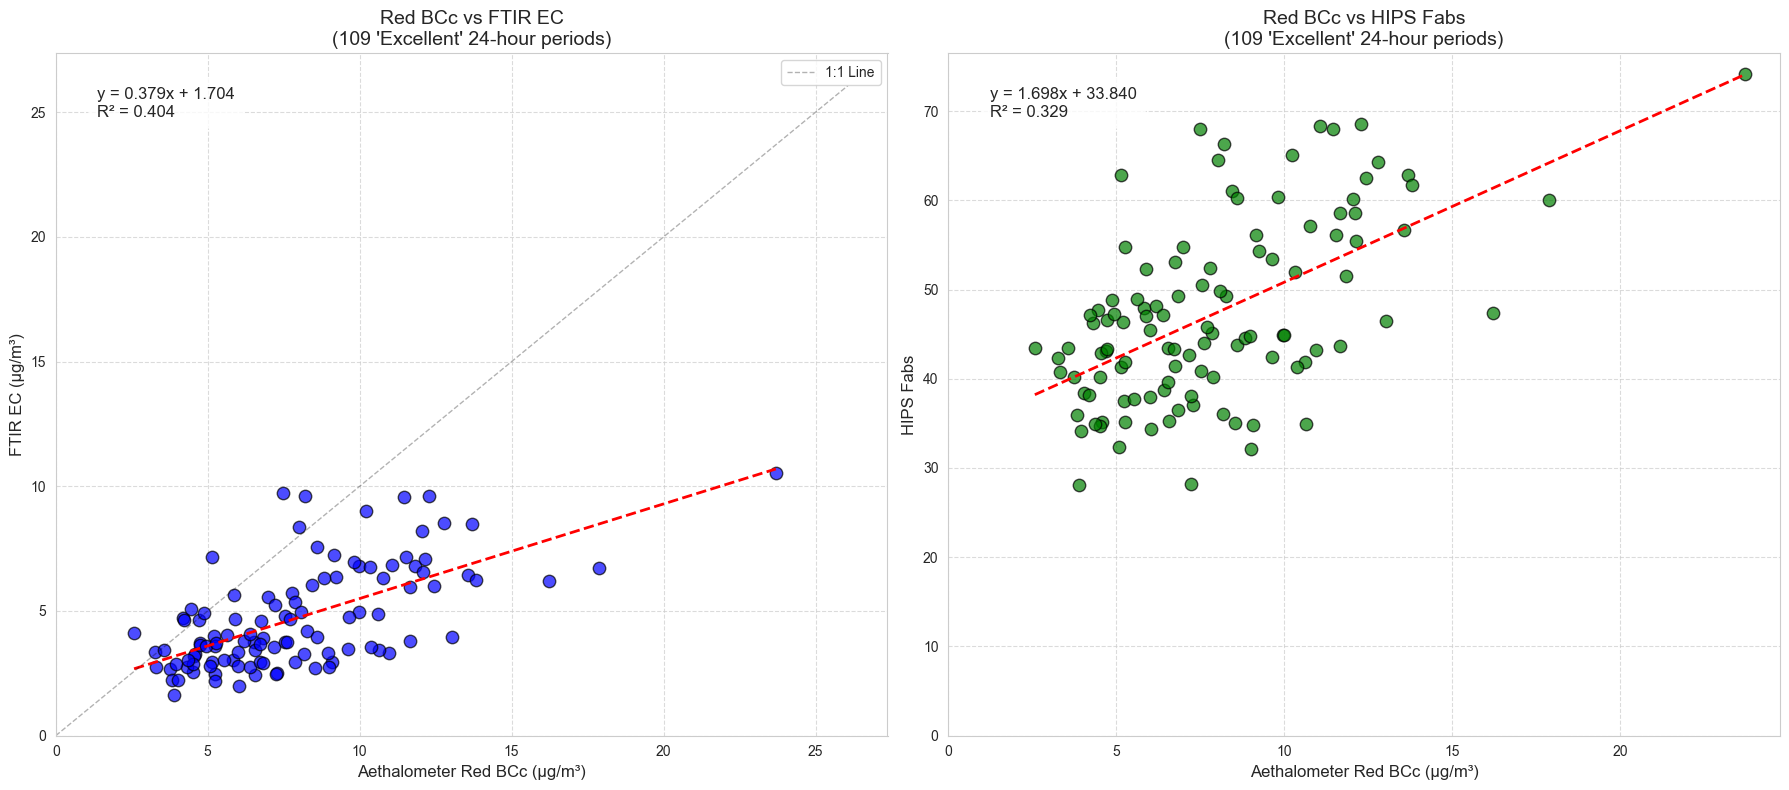

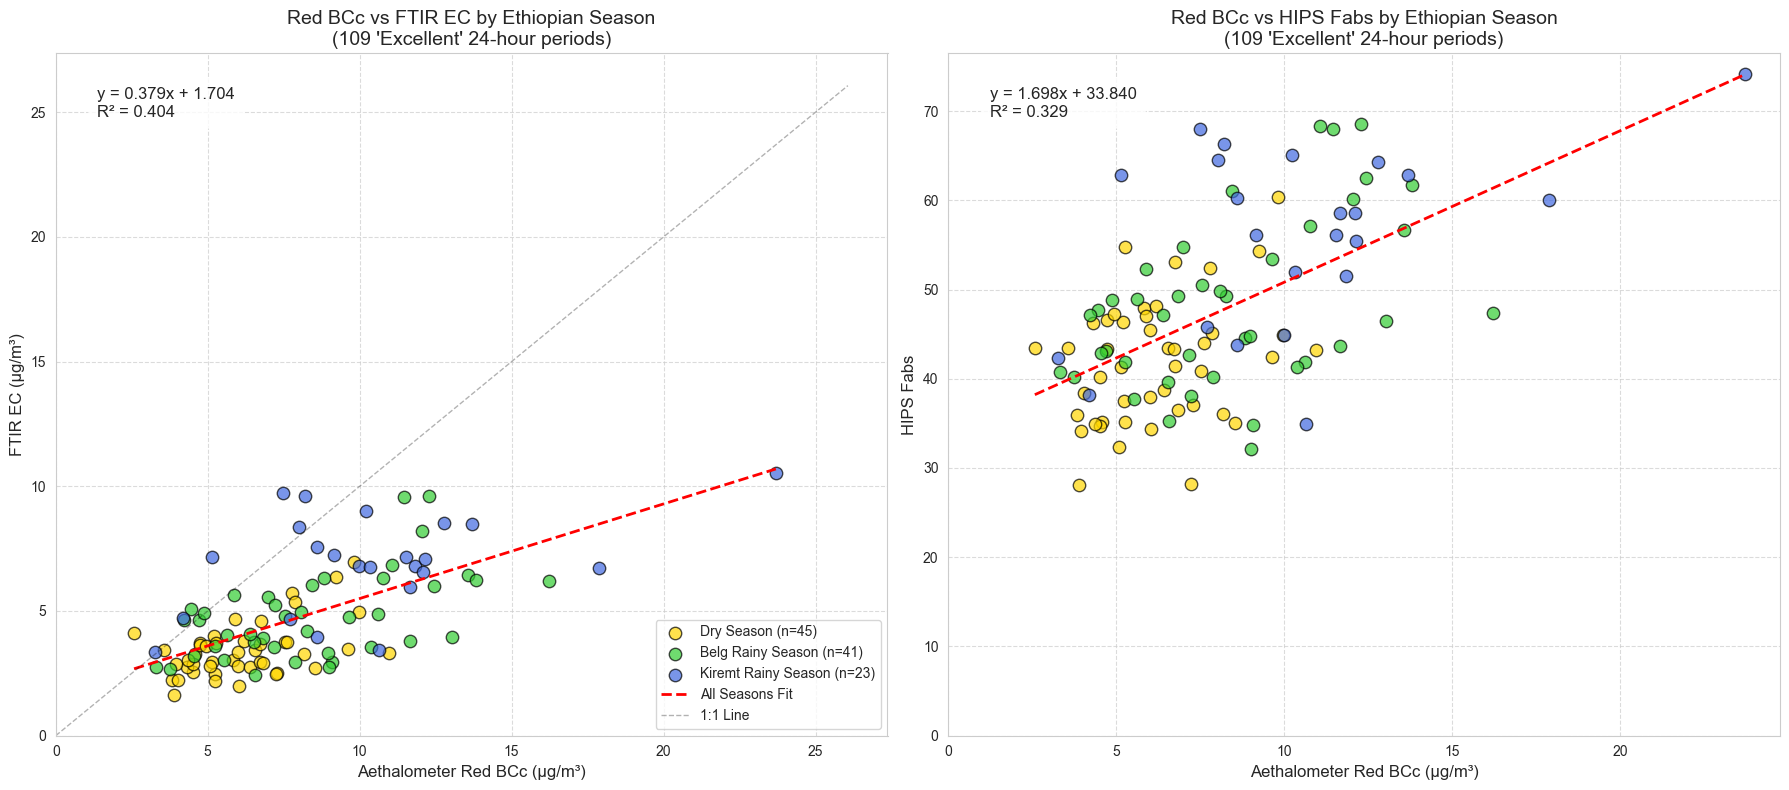


Seasonal Regression Statistics:
                Season  Count  EC_FTIR_Slope  EC_FTIR_Intercept  EC_FTIR_R2  \
0           Dry Season     45          0.283              1.694       0.240   
1    Belg Rainy Season     41          0.298              2.303       0.296   
2  Kiremt Rainy Season     23          0.202              4.873       0.198   

   Fabs_Slope  Fabs_Intercept  Fabs_R2  
0       1.133          34.815    0.097  
1       1.412          36.494    0.229  
2       1.090          44.617    0.212  

Mass Absorption Cross-section (MAC) Values for Red Channel:
Overall MAC: 11.06 m²/g (n=109)

Seasonal MAC Values:
                      mean   std  count
season                                 
Belg Rainy Season    10.69  2.15     41
Dry Season           12.78  2.47     45
Kiremt Rainy Season   8.35  1.47     23


/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_22691/2406137792.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='season', y='red_mac', data=mac_df, ax=ax2, palette='Set3')
/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_22691/2406137792.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(new_labels)


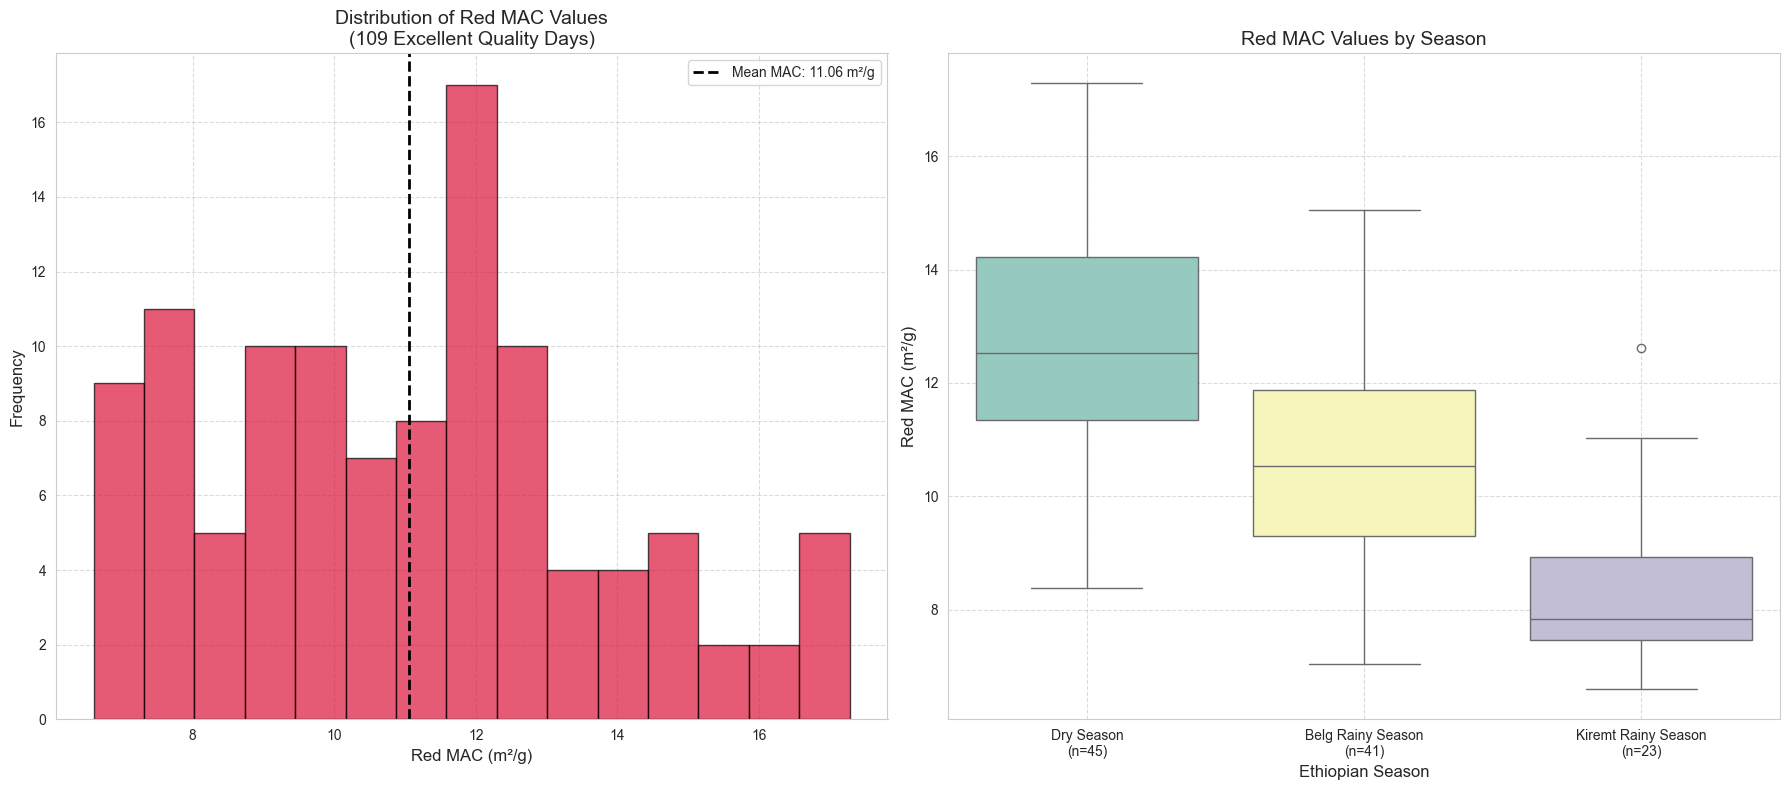

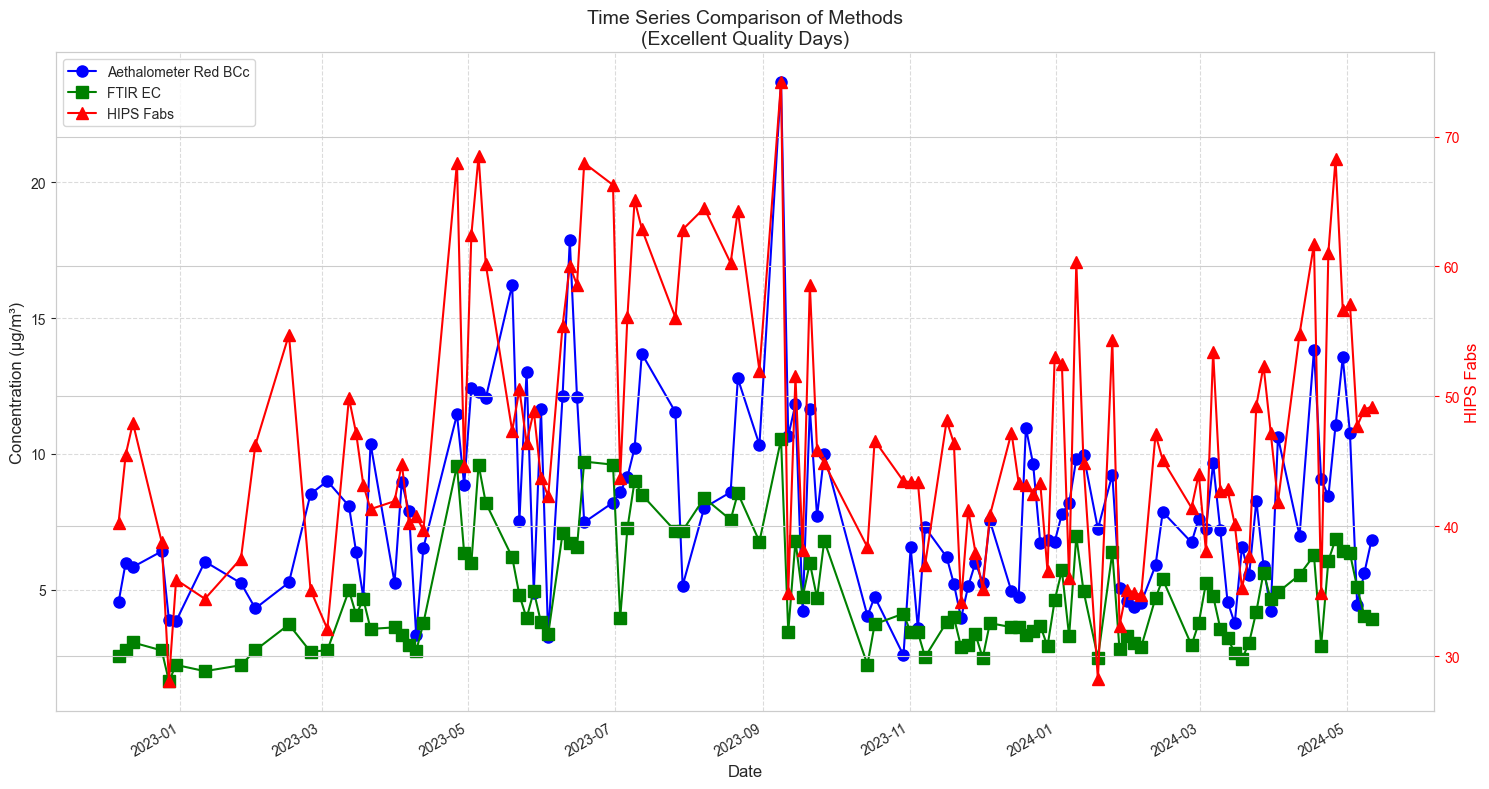

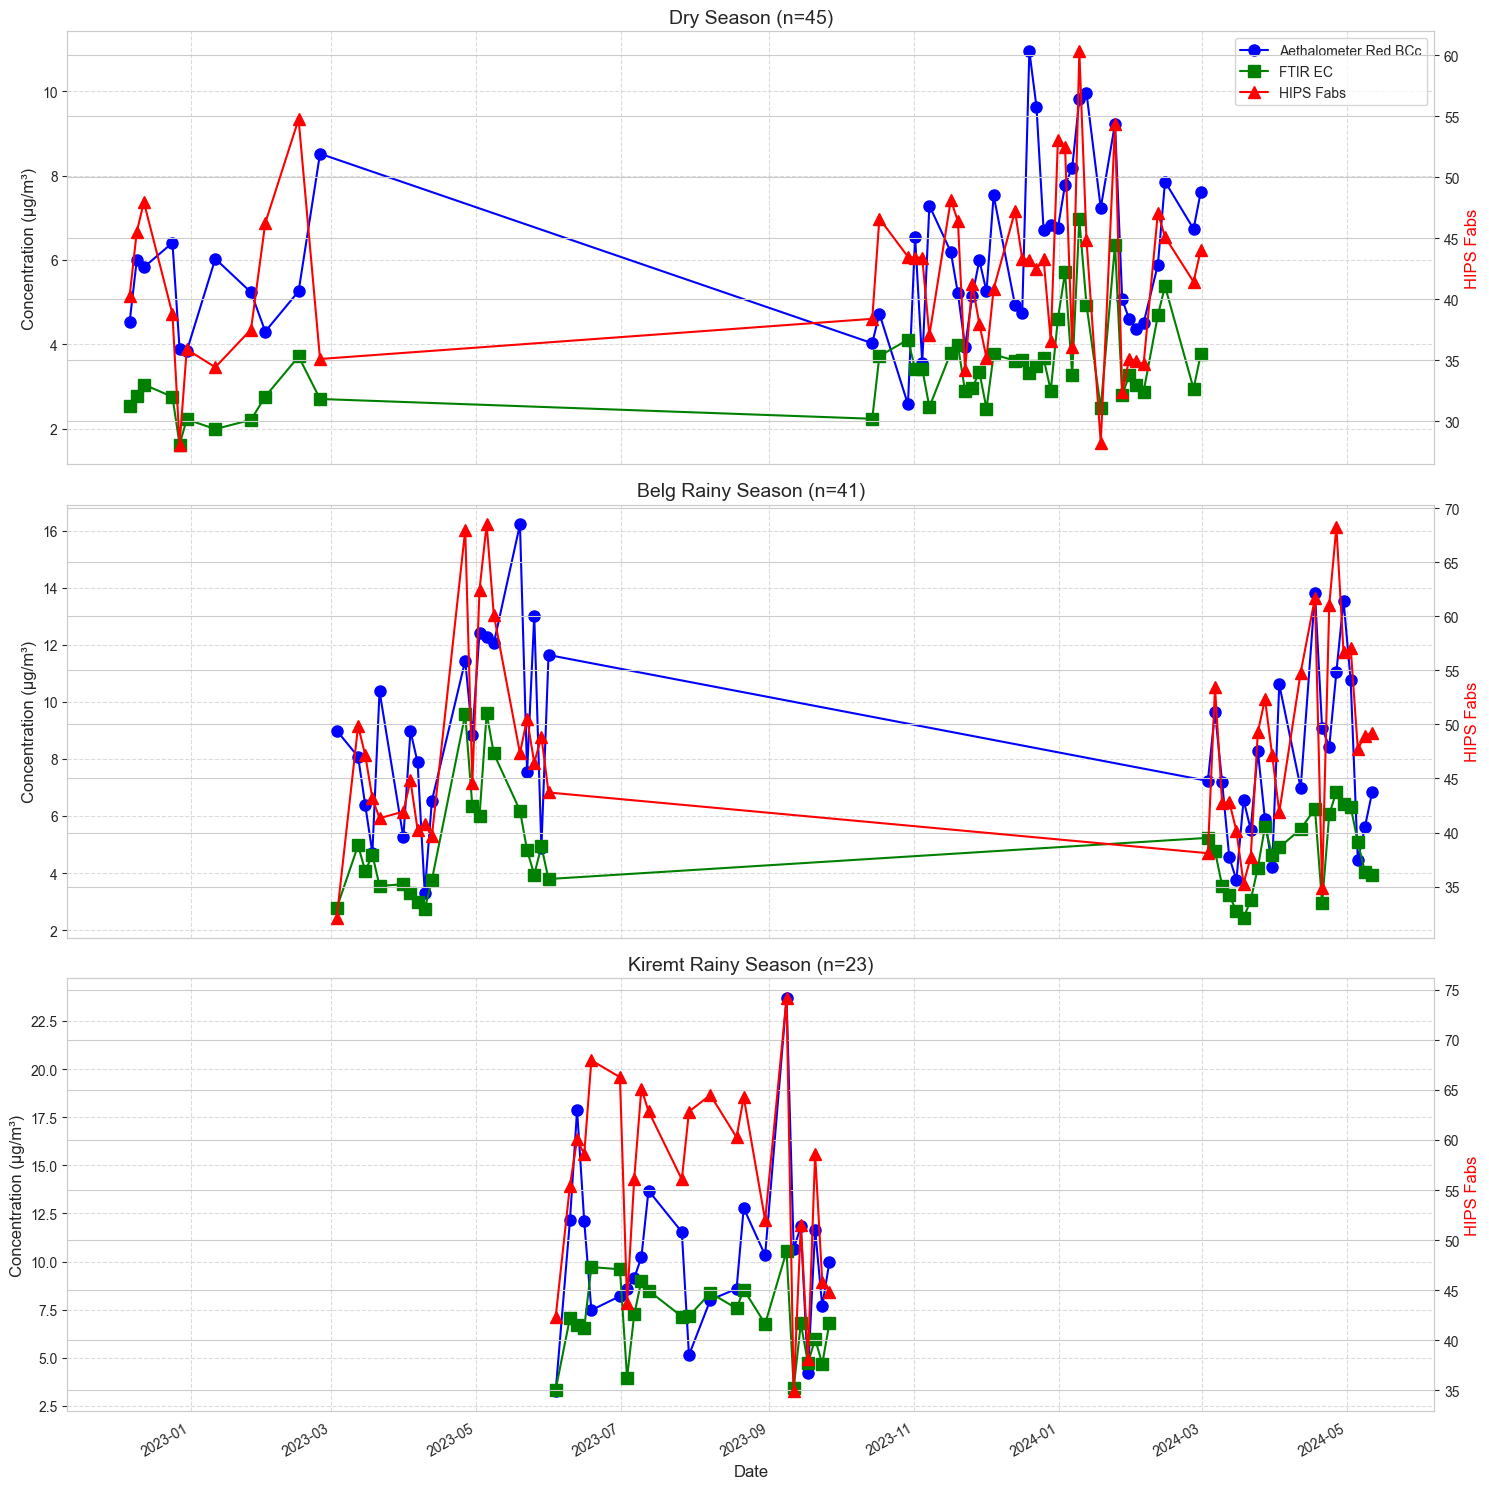


--- Analysis Complete ---
Successfully analyzed 109 overlapping excellent quality days


In [31]:
if __name__ == "__main__":
    results = main()

## Explore Results

After running the analysis, you can explore the results further. Here are some examples of additional analyses you might want to perform:

In [32]:
# Explore overlap data
# Uncomment and run after executing the main function

# Display summary statistics
print("\nSummary Statistics for Overlapping Periods:")
print(results['overlap_df'].describe())

# Display correlation matrix
print("\nCorrelation Matrix:")
corr_cols = ['aeth_mean', 'EC_FTIR', 'Fabs']
print(results['overlap_df'][corr_cols].corr().round(3))


Summary Statistics for Overlapping Periods:
                          start_time                       end_time  \
count                            109                            109   
mean   2023-09-23 08:59:59.999999744  2023-09-24 08:59:59.999999744   
min              2022-12-06 09:00:00            2022-12-07 09:00:00   
25%              2023-05-22 09:00:00            2023-05-23 09:00:00   
50%              2023-10-14 09:00:00            2023-10-15 09:00:00   
75%              2024-01-30 09:00:00            2024-01-31 09:00:00   
max              2024-05-11 09:00:00            2024-05-12 09:00:00   
std                              NaN                            NaN   

          EC_FTIR        Fabs   aeth_count     aeth_mean   aeth_median  \
count  109.000000  109.000000   109.000000    109.000000    109.000000   
mean     4.700291   47.251358  1414.486239   7897.335780   6014.238532   
min      1.625668   28.085699   498.000000   2576.229008   2066.000000   
25%      3.048084  

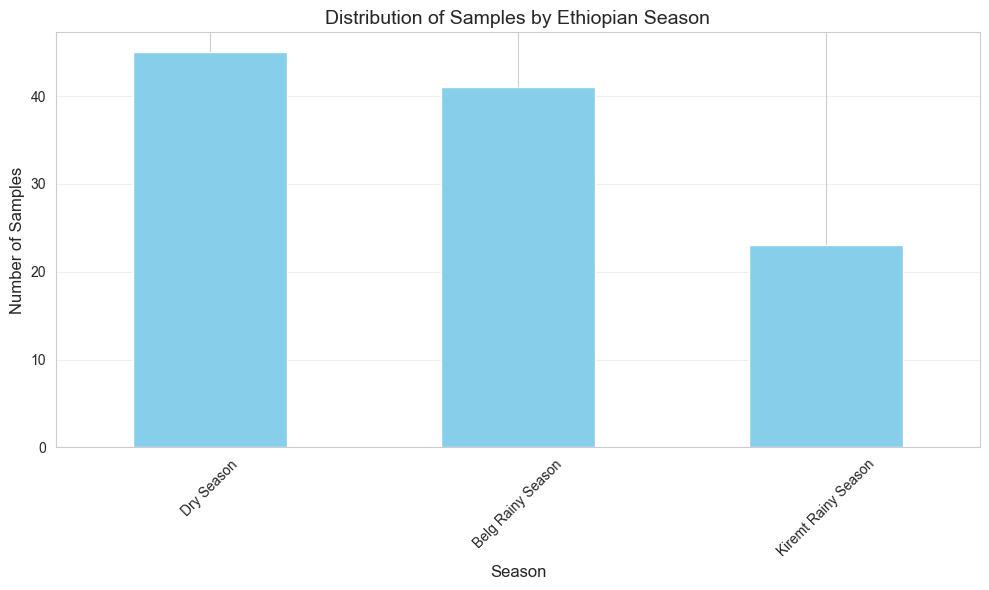

In [33]:
# Additional seasonal analysis
# Uncomment and run after executing the main function

# Plot seasonal distribution
if 'overlap_df' in results and 'season' in results['overlap_df'].columns:
     plt.figure(figsize=(10, 6))
     season_counts = results['overlap_df']['season'].value_counts()
     season_counts.plot(kind='bar', color='skyblue')
     plt.title('Distribution of Samples by Ethiopian Season', fontsize=14)
     plt.xlabel('Season', fontsize=12)
     plt.ylabel('Number of Samples', fontsize=12)
     plt.xticks(rotation=45)
     plt.grid(axis='y', alpha=0.3)
     plt.tight_layout()
     plt.show()